# Flights delays data exploration

## Preliminary Wrangling


In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

In [2]:
frames = {}
# we use a dictionary of frames here to avoid huge data duplication for the year
for i in [1992, 1998, 2004]:
    fname = str(i) + '.csv'
    print('loading ... ', fname)
    frame = pd.read_csv(fname, usecols = ['FlightNum', 
                                          'CRSElapsedTime',
                                          'ActualElapsedTime',
                                          'ArrDelay', 
                                          'DepDelay',
                                          'Distance',
                                          'Month',
                                         ])
    frame.dropna(inplace = True)
    frame['TotalDelay'] = frame['ArrDelay'] + frame['DepDelay']
    frame.drop(columns = ['ArrDelay', 'DepDelay'], inplace = True)
    frame['ElapsedTimePredictionError'] = frame['ActualElapsedTime'] - frame['CRSElapsedTime']
    frame['Distance'] = frame['Distance'].astype(int)
    frames[i] = frame

loading ...  1992.csv
loading ...  1998.csv
loading ...  2004.csv


In [3]:
for f in frames.values():
    print(f.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5020651 entries, 0 to 5092156
Data columns (total 7 columns):
Month                         int64
FlightNum                     int64
ActualElapsedTime             float64
CRSElapsedTime                int64
Distance                      int64
TotalDelay                    float64
ElapsedTimePredictionError    float64
dtypes: float64(3), int64(4)
memory usage: 306.4 MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5227051 entries, 0 to 5384720
Data columns (total 7 columns):
Month                         int64
FlightNum                     int64
ActualElapsedTime             float64
CRSElapsedTime                float64
Distance                      int64
TotalDelay                    float64
ElapsedTimePredictionError    float64
dtypes: float64(4), int64(3)
memory usage: 319.0 MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6987729 entries, 0 to 7129269
Data columns (total 7 columns):
Month                         in

### What is the structure of your dataset?

We have flight databases for 1992 (5020651 entries), 1998 (5227051 entries) and 2004 (6987729 entries) for the USA. The following characteristics are taken in account:

- `Total delay` which is a sum of `Arrival delay` and `Departure delay` in minutes
- `Distance` in miles
- `Month` (between 1...12)
- `CRS elapsed time` in minutes
- `Actual elapsed time` in minutes

### What is/are the main feature(s) of interest in your dataset?
The main interest is the flight delays and what influences on it.


### What features in the dataset do you think will help support your investigation into your feature(s) of interest?
Might be time of the year, distance, etc.

In [4]:
# Helper function to plot a family of visualizations for the years picked by us
def plot_per_year(plot_frame):
    fig, ax = plt.subplots(ncols = len(frames), figsize = [16, 4])
    idx = 0
    for key in frames.keys():
        frame = frames[key]
        plot_frame(frame, ax[idx])
        ax[idx].set_title(key);
        idx += 1
    plt.show()    

## Univariate Exploration

First research any kind of temporal dependencies.

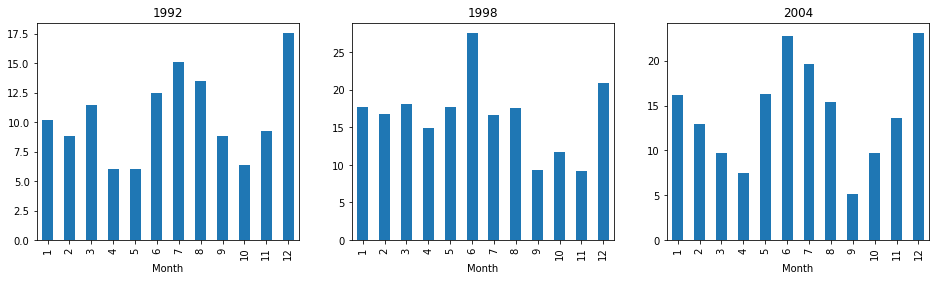

In [5]:
plot_per_year(lambda frame, ax: 
    frame.groupby('Month')['TotalDelay'].mean().plot.bar(x = 'Month', y = 'TotalDelay', ax = ax))

_Result_: Looks like on summer vacations and in december there are the most delays (which is not surprising).

Now we are going to look at the `TotalDelay` as a random variable for different years. We'll average it per `FlightNum`.

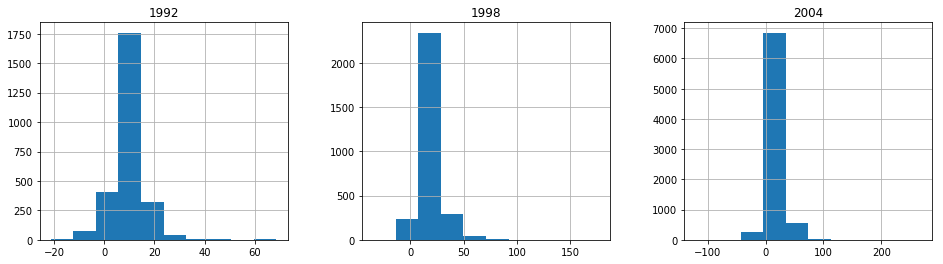

In [6]:
plot_per_year(lambda frame, ax:
    frame.groupby(['FlightNum']).mean().hist('TotalDelay', ax = ax))

Default bin for histogram seems to be pretty inaccurate, let's "zoom in".

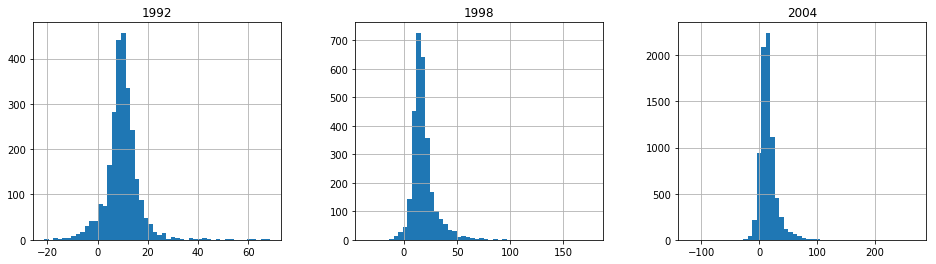

In [7]:
plot_per_year(lambda frame, ax:
    frame.groupby(['FlightNum']).mean().hist('TotalDelay', bins = 50, ax = ax))

`TotalDelay` looks having unimodal structure. The form of the distrubution resembles Gaussian, but in fact it isn't due to quite "heavy" tails for Gaussian.

Let's have a look at some random factors which can influence on `TotalDelay`. Also we are interested in checking the statement of article [1] which says, there's a connection between scheduled time, `CRSElapsedTime` in our case, and `TotalDelay`, and in earlier years **the delays were higher because the predicted time was more accurate, and since some year the estimate became more pessimistic which led to reduce of delays**. First we look at the standard deviation of  CRS prediction (averaged per `FlightNum`).

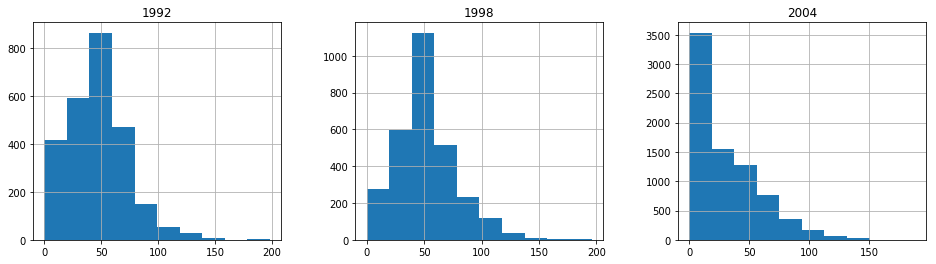

In [8]:
plot_per_year(lambda frame, ax:
    frame.groupby(['FlightNum']).std().hist('CRSElapsedTime', ax = ax))

The bin size as again too coarse, let's make it smaller.

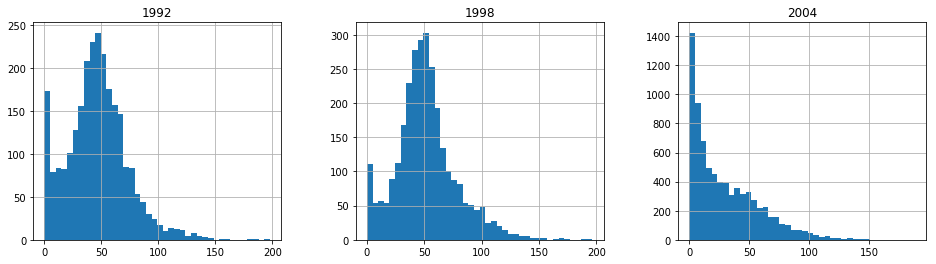

In [9]:
plot_per_year(lambda frame, ax:
    frame.groupby('FlightNum').std().hist('CRSElapsedTime', ax = ax, bins = 40))

We have a curious picture now. In the years 1992 and 1998, the CRS used to predict the elapsed time with a certain standard deviation, which was ~50 min., and in 2004 predicted time deviates less. There is also an anomaly when the it doesn't deviate at all, but that's probably due to small amount of observations. Let's filter out small groups and consider only flights which took place at least 100 times that year.

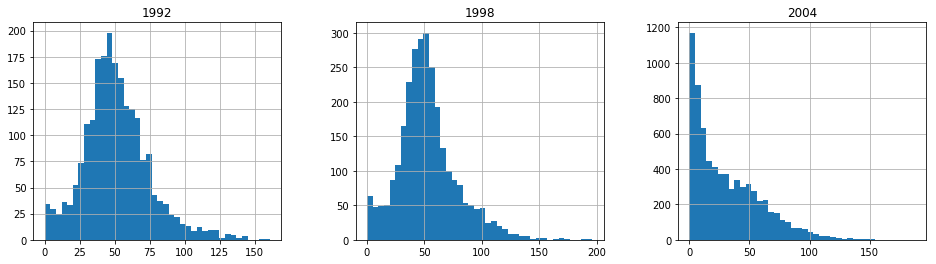

In [10]:
plot_per_year(lambda frame, ax:
              frame.groupby('FlightNum')
              .filter(lambda x: len(x) > 100)
              .groupby('FlightNum').std().hist('CRSElapsedTime', bins = 40, ax = ax))

So still in 2004 CRS was more certain in predicted value of elapsed time, which might be also caused by inaccuracy of estimation. Looking at the time prediction error below we see that in 2004 isn't less in comparison with earlier years ...

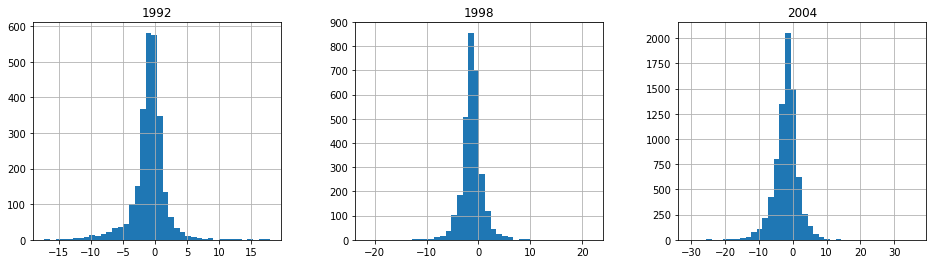

In [11]:
plot_per_year(lambda frame, ax:
             frame.groupby('FlightNum').mean().hist('ElapsedTimePredictionError', bins = 40, ax = ax))

... even though the annual amount of both unique flights and flights in generals increased.

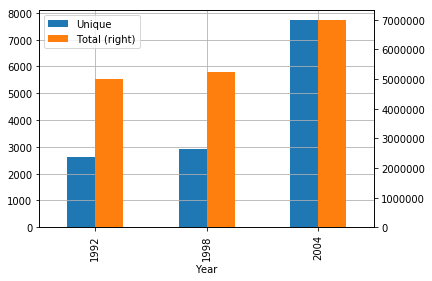

In [12]:
number_of_flights = {'Year':[], 'Unique':[], 'Total':[]}
for key in frames.keys():
    number_of_flights['Year'] += [key]
    number_of_flights['Unique'] += [frames[key]['FlightNum'].nunique()]
    number_of_flights['Total'] += [frames[key]['FlightNum'].count()]
number_of_flights = pd.DataFrame.from_dict(number_of_flights)
number_of_flights.plot.bar(x = 'Year', secondary_y = 'Total', grid = True)
plt.show();

Also let's see if the distance directly affect `TotalDelay`. Thus let's look at the flight distance as a random variable.

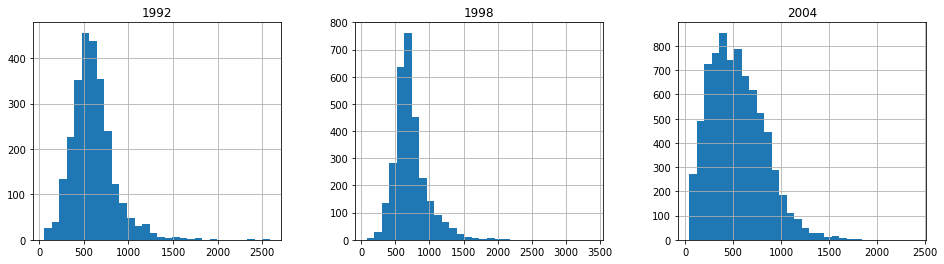

In [13]:
plot_per_year(lambda frame, ax:
    frame.groupby(['FlightNum']).mean().hist('Distance', ax = ax, bins = 30))

In [14]:
for f in frames.values():
    print('99 percent distance quantile %f' % f.groupby('FlightNum')['Distance'].mean().quantile(0.99))

99 percent distance quantile 1341.714363
99 percent distance quantile 1532.683756
99 percent distance quantile 1349.169973


### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

We looked at the `TotalDelay` as a random variable, which turned out to be univariative when averaging for `FlightNum`. When averaging per `Month` it shows clear increase on summer vacation period and in December for any of investigated years. We prepared some data to check the hypothesis in [1], basically `CRSElapsedTime`, where we had to filter out some insignificant groups per `FlightNum`.

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

`CRSElapsedTime` averaged per `FlightNum` showed some unusual peak at 0, which was gone when checking the number of points being averaged. Also all the histograms had to be adjusted because were too coarse with default bin size.

## Bivariate/Multivariate Exploration

So we know now that `CRSElapsedTime` has considerably same accuracy for all the observed years, and if the delays decreased, it might be that `CRSElapsedTime` in fact increased for same distances. Therefore we should compare `CRSElapsedTime` for different years. `FlightNum` no longer makes sense as a group feature, because it might have changed in several years, so we split the `Distance` in intervals and average within them.

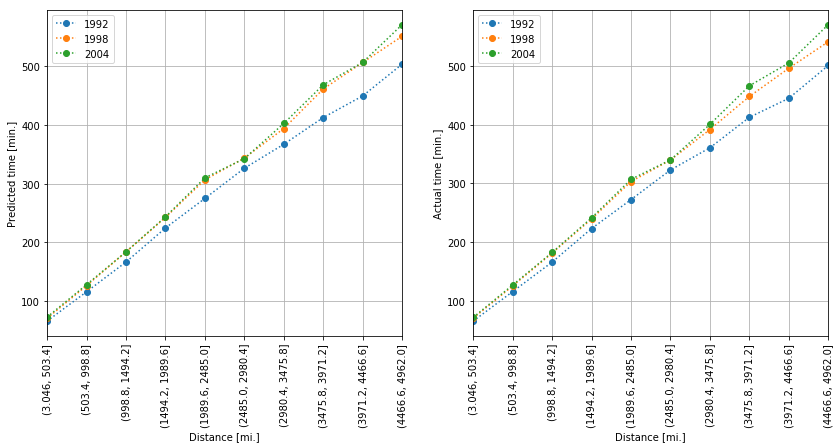

In [15]:
fig, ax = plt.subplots(ncols = 2, figsize = [14, 6])
for frame in frames.values():
    frame.groupby(pd.cut(frame['Distance'], 10))['CRSElapsedTime'].mean() \
    .plot(x = 'Distance', y = 'CRSElapsedTime', rot = 90, marker = 'o', grid = True, linestyle = ':', ax = ax[0])
    frame.groupby(pd.cut(frame['Distance'], 10))['ActualElapsedTime'].mean() \
    .plot(x = 'Distance', y = 'ActualElapsedTime', rot = 90, marker = 'o', grid = True, linestyle = ':', ax = ax[1])
ax[0].set_ylabel('Predicted time [min.]')
ax[0].set_xlabel('Distance [mi.]')
ax[0].legend(frames.keys());
ax[1].set_ylabel('Actual time [min.]')
ax[1].set_xlabel('Distance [mi.]')
ax[1].legend(frames.keys());  

So for large distances, which correspond to `CRSElapsedTime` of 300 min. and more, predicted time in 1998 and 2004 seems to increase. But that's due to the fact that `ActualElapsedTime` has also increased. Besides that, 99% of the flights are for short distances (within ~1500 ml.) for all years, so the deviation for long distances is not depictive anyways.

Let's zoom distance in.

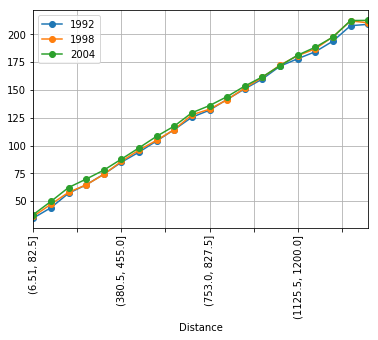

In [16]:
for frame in frames.values():
    f = frame.loc[frame['Distance'] < 1500]
    f.loc[f['Distance'] < 1500] \
    .groupby(pd.cut(f['Distance'], 20))['CRSElapsedTime'] \
    .mean().plot(x = 'Distance', y = 'CRSElapsedTime', rot = 90, marker = 'o', grid = True)
plt.legend(frames.keys())
plt.show()

So wee see that `CRSElapsedTime` perfectly predicts the distance for 99% of it and didn't change in years.

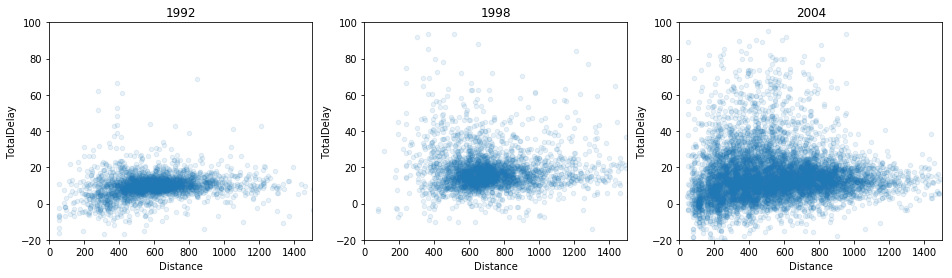

In [17]:
plot_per_year(lambda frame, ax:
    frame.groupby('FlightNum').mean() \
         .plot.scatter(x = 'Distance', y = 'TotalDelay',
                       ylim = [-20, 100],
                       xlim = [0, 1500],
                       alpha = 0.1, ax = ax))

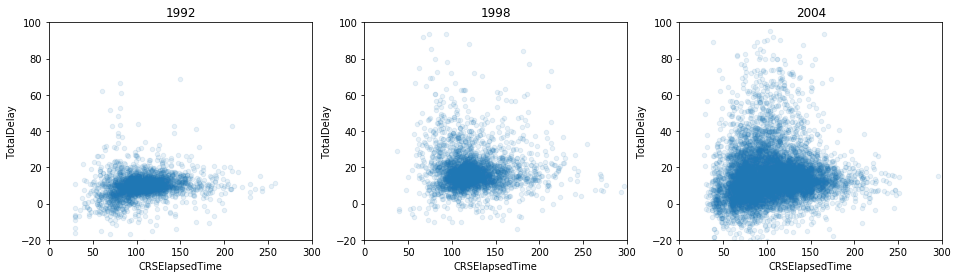

In [18]:
plot_per_year(lambda frame, ax:
    frame.groupby('FlightNum').mean() \
         .plot.scatter(x = 'CRSElapsedTime', y = 'TotalDelay',
                       ylim = [-20, 100],
                       xlim = [0, 300],
                       alpha = 0.1, ax = ax))

So `TotalDelay` looks independent from both distance and `CRSElapsedTime`. The spread increases each year, but that's just due to more flights. **So on the dataset we have the hypothesis in [1] cannot be proven**.

Also let's summorize the season influence on `TotalDelay`, such that we can compare it for different years on one graph to see how they depend on year.

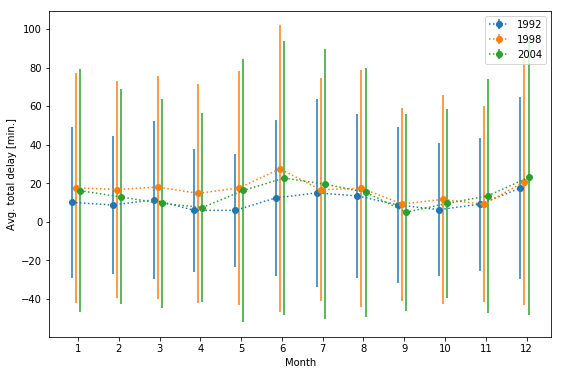

In [19]:
fig, ax = plt.subplots(figsize = [9, 6])
step = 0.1
shift = -len(frames)/2*step
for year, frame in frames.items():
    mean = frame.groupby('Month')['TotalDelay'].mean()
    std = frame.groupby('Month')['TotalDelay'].std()
    plt.errorbar(np.arange(1 + shift, 13 + shift), mean, std, fmt = ':o')
    shift += step
plt.xlabel('Month')
plt.ylabel('Avg. total delay [min.]')
plt.xticks(range(1, 13))
plt.legend(frames.keys())
plt.show()

# Note: seaborn pointplot doesn't work here due to huge amount of data

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

`TotalDelay` turned out to be independent from `Distance`, `CRSElapsedTime` and `ActualElapsedTime`, which shows that the assumption in [1] isn't true on our dataset. Also `CRSElapsedTime`, in fact, quite precisely predicts `ActualElapsedTime` (which denies the fact from the article that the time is overestimated in order to reduce delays), at least on 99% of the flights.


## References
[1] https://www.npr.org/2018/02/20/587195947/hidden-brain-airline-delays?t=1553068598087&t=1553979166718